In [24]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

# Doubt: NN may have bad landscapes. BFGS may perform worse than Adam at high loss.

np.random.seed(1)
torch.manual_seed(1)

# Define Transformer


# (t,rho,z) -> (t',rho',z')
class T(nn.Module):
    def __init__(self,w=256,a=0.,M=1.):
        super(T, self).__init__()
        self.l1 = nn.Linear(2,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,4)
        self.a = a
        self.M = torch.nn.Parameter(torch.ones(1,)*1., requires_grad=False)
        self.eps = torch.nn.Parameter(torch.ones(1,)*0.01, requires_grad=False)
    
    def forward(self, x):
        bs = x.shape[0]
        # These non-polynomial activation function may not lead to power laws
        #f = nn.Tanh()
        #f = nn.SiLU()
        #f = Rational()
        f = nn.ReLU()
        self.t = x[:,[0]]
        self.x = x[:,[1]]
        self.y = x[:,[2]]
        self.z = x[:,[3]]
        self.r = torch.sqrt(self.x**2+self.y**2+self.z**2)
        self.u = torch.sqrt(self.r/(2*self.M))

        self.rho = torch.unsqueeze(torch.sqrt(x[:,1]**2+x[:,2]**2),dim=1)
        self.rhoz = torch.transpose(torch.stack([self.rho,self.z]),0,1)[:,:,0]
        
        self.x1 = f(self.l1(self.rhoz))
        self.x2 = f(self.l2(self.x1))**2
        self.x3 = self.l3(self.x2)

        self.dt = self.x3[:,[0]]
        self.drho = self.x3[:,[1]]
        self.dphi = self.x3[:,[2]]
        self.dz = self.x3[:,[3]]
        nn_out = torch.empty((x.shape[0], 4), requires_grad=False)
        nn_out[:,[0]] = self.dt
        nn_out[:,[1]] = (-self.y*self.dphi+self.x*self.drho)
        nn_out[:,[2]] = (self.x*self.dphi+self.y*self.drho)
        nn_out[:,[3]] = self.dz*self.z

        return x + self.eps.unsqueeze(dim=0)*nn_out
    
    def set_a(self,a):
        self.a = a
        
    def batch_jacobian(self, func, x, create_graph=False):
        # x in shape (Batch, Length)
        def _func_sum(x):
            return func(x).sum(dim=0)
        return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)
    
    def transform_g(self, x):
        jac_ts = self.batch_jacobian(self.forward, x, create_graph=True)
        jac_inv_ts = torch.inverse(jac_ts)
        return torch.matmul(torch.matmul(jac_inv_ts.permute(0,2,1), g(x)),jac_inv_ts)
        
    def jac(self, x):
        jac_ts = self.batch_jacobian(self.forward, x, create_graph=True)
        return jac_ts
    

def grow(t1, t2, w_s, w_l):

    w_mask = torch.zeros(w_l,w_l)
    w_mask[:w_s,:w_s] = torch.ones(w_s,w_s)

    b_mask = torch.zeros(w_l,)
    b_mask[:w_s] = torch.ones(w_s,)

    t2.l2.weight.data = t2.l2.weight.data*w_mask
    t2.l2.weight.data[:w_s,:w_s] = t1.l2.weight.data
    t2.l2.bias.data = t2.l2.bias.data*b_mask
    t2.l2.bias.data[:w_s] = t1.l2.bias.data

    t2.l1.weight.data[:w_s,:] = t1.l1.weight.data
    t2.l1.bias.data[:w_s] = t1.l1.bias.data

    t2.l3.weight.data[:,:w_s] = t1.l3.weight.data
    t2.l3.bias.data = t1.l3.bias.data
    return t2
    

In [25]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

n_train = 1000

W = torch.normal(0,1,size=(n_train,4),requires_grad=True)
input_ = torch.empty(n_train,4, requires_grad=False)
input_[:,0] = (torch.rand(n_train, requires_grad=True)-0.5)*3.0 + 1.5
rs = torch.linspace(3,4,steps=n_train+1)[:n_train]
input_[:,1:] = W[:,1:]/torch.norm(W[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs, dim=1)

n_test = 1000

W_test = torch.normal(0,1,size=(n_test,4),requires_grad=True)
input_test_ = torch.empty(n_test,4, requires_grad=False)
input_test_[:,0] = (torch.rand(n_test, requires_grad=True)-0.5)*3.0 + 1.5
rs_test = torch.linspace(3,4,steps=n_test+1)[:n_test]
input_test_[:,1:] = W_test[:,1:]/torch.norm(W_test[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs_test, dim=1)



In [39]:
import copy
import time

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# w/wo growing network
# Tanh, Relu, Relu2 activation, last-layer act(other relu). Even: Should we use spline networks?
# Hybrid: Adam + LBFGS
# Possible overfitting: train & test gap
# LBFGS usage

#ws = [50,60,70,80,90,100,120,140,160,180,200,250,300,350,400]
ws = [5,10,15,20,25,30,35,40,45,50]
#ws = [14]
#ws = [2,4]
losses_w = []
losses_w_test = []
times = []

a_s = [0.0]

w_i = 0

for w in ws:
    
    print("w={}".format(w))
    if w_i == 0:
        t = T(w=w, a=0.0, M=1.0)
    else:
        sd = t.state_dict()
        t_old = T(w=w_old, a=0.0, M=1.0)
        t_old.load_state_dict(sd)
        t = T(w=w, a=0.0, M=1.0)
        t = grow(t_old, t, w_old, w)
    w_i = w_i + 1


    losses_a = []
    losses_all = []
    a_i = 0



    for a_kerr in a_s:
        M = 1.0
        r_c = M + np.sqrt(M**2-a_kerr**2)
        print("a_kerr={}".format(a_kerr))
        print("M={}".format(M))
        print("r_c={}".format(r_c))
        #t = T(w=400, a=a_kerr, M=M)
        t.set_a(a_kerr)
        a_i += 1


        # Kerr Metric
        def g(x_):
            a = a_kerr
            bs = x_.shape[0]
            t = x_[:,0]
            x = x_[:,1]
            y = x_[:,2]
            z = x_[:,3]
            rho = torch.sqrt(x**2+y**2)
            r = torch.sqrt(x**2+y**2+z**2)
            costheta = z/r
            sintheta = rho/r
            sin2theta = 2*sintheta*costheta
            cos2theta = 2*costheta**2 - 1
            cosphi = x/rho
            sinphi = y/rho
            sigma = r**2 + a**2*costheta**2
            zeta = torch.sqrt(r**2+a**2)
            sq2 = torch.sqrt(torch.tensor(2., dtype=torch.float, requires_grad=False))

            u1 = a**2 + 2*r**2 + a**2*cos2theta
            zeta = torch.sqrt(a**2+r**2)
            u2 = u1/(zeta*torch.sqrt(M*r))
            u3 = 8*a*M/sigma
            u4 = zeta**2 + 2*a**2*M*r*sintheta**2/sigma

            g00 = -1 + 2*M*r/sigma
            g01 = g10 = 1/4*sintheta*(sq2*u2*cosphi+u3*sinphi)
            g02 = g20 = 1/4*sintheta*(-u3*cosphi+sq2*u2*sinphi)
            g03 = g30 = costheta*u2/sq2**3
            g11 = (8*costheta**2*cosphi**2*sigma-u2**2*r**2*cosphi**2*sintheta**2+8*u4*sinphi**2)/(8*r**2)
            g12 = g21 = cosphi*(8*costheta**2*sigma-u2**2*r**2*sintheta**2-8*u4)*sinphi/(8*r**2)
            g13 = g31 = costheta*(-8*sigma-u2**2*r**2)*cosphi*sintheta/(8*r**2)
            g22 = (8*cosphi**2*u4+8*costheta**2*sigma*sinphi**2-u2**2*r**2*sintheta**2*sinphi**2)/(8*r**2)
            g23 = g32 = costheta*(-8*sigma-u2**2*r**2)*sintheta*sinphi/(8*r**2)
            g33 = sintheta**2 + costheta**2*(-u2**2*r**2+8*a**2*sintheta**2)/(8*r**2)

            stack1 = torch.stack([g00, g01, g02, g03])
            stack2 = torch.stack([g10, g11, g12, g13])
            stack3 = torch.stack([g20, g21, g22, g23])
            stack4 = torch.stack([g30, g31, g32, g33])

            gs = - torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
            return gs
        
        def euclidean_loss(t,inputs):
            gp = t.transform_g(inputs)
            bs = gp.shape[0]
            minkowski_metric = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=2) * torch.unsqueeze(torch.diag(torch.tensor([-1.,-1.,-1.], dtype=torch.float, requires_grad=True)), dim=0)
            return torch.mean((gp[:,1:,1:]-minkowski_metric)**2)



        lr = 1e-2*(5/w)**2
        '''if w_i == 0:
            epochs = 2500
            BFGS_epoch = 2000
        else:
            epochs = 500
            BFGS_epoch = 0'''
        
        # We need to understand LBFGS better
        epochs = 15000
        switch_epoch = 3000
        BFGS_epoch = 1000000

        optimizer = optim.Adam(t.parameters(), lr=lr, eps=1e-8)
        #optimizer = optim.SGD(t.parameters(),lr=lr)
        #optimizer = optim.LBFGS(t.parameters(), lr=0.1, max_iter=1e10, max_eval=1e10, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100, line_search_fn='strong_wolfe')
        #optimizer = optim.LBFGS(t.parameters(), lr=0.1, max_iter=100, max_eval=1e10, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100)



        #epochs = 100
        #optimizer = optim.LBFGS(t.parameters(), lr=1, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100, line_search_fn="strong_wolfe")
        #optimizer = optim.LBFGS(t.parameters(), lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

        log_save = 100000

        losses = []

        n_train = 1000
        
        best_loss = 10000
        
        start = time.time()

        for epoch in range(epochs):

            if (epoch+1) % switch_epoch == 0:
                for opt_param in optimizer.param_groups:
                    lr = lr * 0.5
                    opt_param['lr'] = lr

            if epoch == BFGS_epoch:
                # BFGS learning rate. How to set?
                optimizer = optim.LBFGS(t.parameters(), lr=0.1, max_iter=1e10, max_eval=1e10, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100, line_search_fn='strong_wolfe')

            if epoch < BFGS_epoch:
                log = 100
                batch_size = n_train
            else:
                log = 1
                batch_size = n_train
            t.train()


            choices = np.random.choice(n_train, batch_size, replace=False)
            inputs = input_[choices]

            # -------------------------------------------
            def loss_closure():
                if torch.is_grad_enabled():
                    optimizer.zero_grad()
                loss_inner = euclidean_loss(t,inputs)
                #if loss_inner.requires_grad:
                    #loss_inner.backward(retain_graph=True)
                    #loss_inner.backward()
                loss_inner.backward(retain_graph=True)
                return loss_inner
            # -------------------------------------------
            loss = loss_closure()
            # best_loss is trick for better scaling laws
            if loss < best_loss:
                best_loss = loss
                best_epoch = epoch
                def loss_closure_test():
                    if torch.is_grad_enabled():
                        optimizer.zero_grad()
                    loss_inner = euclidean_loss(t,input_test_)
                    return loss_inner
                loss_test = loss_closure_test()
            optimizer.step(loss_closure)  # get loss, use to update wts

            losses.append(loss.detach().numpy())
            losses_all.append(loss.detach().numpy())
            '''loss = euclidean_loss(g,t,inputs)
            loss.backward()
            optimizer.step()'''
            

            if epoch%log == 0:
                print('Epoch:  %d | loss: %.12f ' %(epoch, loss))

    end = time.time()
    duration = end - start
    print("time={}".format(duration))
    times.append(duration)


                
    w_old = w
    losses_w.append(best_loss.detach().numpy())
    losses_w_test.append(loss_test.detach().numpy())
    print("best_train_loss={}".format(best_loss.detach().numpy()))
    print("test_loss={}".format(loss_test.detach().numpy()))
    print("best_epoch={}".format(best_epoch))
    
np.save('./results_nn/grow_relu2last_adam_lrdecay',np.array([ws, losses_w, times, losses_w_test]))


w=5
a_kerr=0.0
M=1.0
r_c=2.0
Epoch:  0 | loss: 0.840038895607 
Epoch:  100 | loss: 0.220892041922 
Epoch:  200 | loss: 0.011808759533 
Epoch:  300 | loss: 0.007408276200 
Epoch:  400 | loss: 0.005450650118 
Epoch:  500 | loss: 0.004063544329 
Epoch:  600 | loss: 0.003507145448 
Epoch:  700 | loss: 0.003068746533 
Epoch:  800 | loss: 0.002919696271 
Epoch:  900 | loss: 0.002911941381 
Epoch:  1000 | loss: 0.002808196237 
Epoch:  1100 | loss: 0.002858462976 
Epoch:  1200 | loss: 0.002822192619 
Epoch:  1300 | loss: 0.003009750741 
Epoch:  1400 | loss: 0.003038014984 
Epoch:  1500 | loss: 0.003112118924 
Epoch:  1600 | loss: 0.003081937321 
Epoch:  1700 | loss: 0.003082874231 
Epoch:  1800 | loss: 0.003016611096 
Epoch:  1900 | loss: 0.002996519208 
Epoch:  2000 | loss: 0.002950438531 
Epoch:  2100 | loss: 0.003023384605 
Epoch:  2200 | loss: 0.003028366482 
Epoch:  2300 | loss: 0.003080296330 
Epoch:  2400 | loss: 0.003162111389 
Epoch:  2500 | loss: 0.003244433319 
Epoch:  2600 | loss: 

Epoch:  6700 | loss: 0.000021385300 
Epoch:  6800 | loss: 0.000021152799 
Epoch:  6900 | loss: 0.000020927055 
Epoch:  7000 | loss: 0.000020698908 
Epoch:  7100 | loss: 0.000020461450 
Epoch:  7200 | loss: 0.000020233094 
Epoch:  7300 | loss: 0.000020008749 
Epoch:  7400 | loss: 0.000019830914 
Epoch:  7500 | loss: 0.000019549005 
Epoch:  7600 | loss: 0.000019270170 
Epoch:  7700 | loss: 0.000019035930 
Epoch:  7800 | loss: 0.000018776202 
Epoch:  7900 | loss: 0.000018495672 
Epoch:  8000 | loss: 0.000018184659 
Epoch:  8100 | loss: 0.000017832377 
Epoch:  8200 | loss: 0.000017737992 
Epoch:  8300 | loss: 0.000017596434 
Epoch:  8400 | loss: 0.000017386295 
Epoch:  8500 | loss: 0.000017261829 
Epoch:  8600 | loss: 0.000017023405 
Epoch:  8700 | loss: 0.000016916931 
Epoch:  8800 | loss: 0.000016618293 
Epoch:  8900 | loss: 0.000016449661 
Epoch:  9000 | loss: 0.000016266811 
Epoch:  9100 | loss: 0.000016167905 
Epoch:  9200 | loss: 0.000016153132 
Epoch:  9300 | loss: 0.000016069549 
E

Epoch:  13300 | loss: 0.000004814908 
Epoch:  13400 | loss: 0.000004802288 
Epoch:  13500 | loss: 0.000004810734 
Epoch:  13600 | loss: 0.000004804950 
Epoch:  13700 | loss: 0.000004789918 
Epoch:  13800 | loss: 0.000004784312 
Epoch:  13900 | loss: 0.000004785756 
Epoch:  14000 | loss: 0.000004758072 
Epoch:  14100 | loss: 0.000004745974 
Epoch:  14200 | loss: 0.000004744781 
Epoch:  14300 | loss: 0.000004738508 
Epoch:  14400 | loss: 0.000004732447 
Epoch:  14500 | loss: 0.000004728794 
Epoch:  14600 | loss: 0.000004723400 
Epoch:  14700 | loss: 0.000004721242 
Epoch:  14800 | loss: 0.000004714394 
Epoch:  14900 | loss: 0.000004712446 
time=353.53910303115845
best_train_loss=4.693003575084731e-06
test_loss=6.634071723965462e-06
best_epoch=14999
w=20
a_kerr=0.0
M=1.0
r_c=2.0
Epoch:  0 | loss: 0.000004692957 
Epoch:  100 | loss: 0.000004547941 
Epoch:  200 | loss: 0.000004439959 
Epoch:  300 | loss: 0.000004259837 
Epoch:  400 | loss: 0.000004058591 
Epoch:  500 | loss: 0.000003907874 

Epoch:  4600 | loss: 0.000001364904 
Epoch:  4700 | loss: 0.000001349484 
Epoch:  4800 | loss: 0.000001341861 
Epoch:  4900 | loss: 0.000001347864 
Epoch:  5000 | loss: 0.000001356462 
Epoch:  5100 | loss: 0.000001335850 
Epoch:  5200 | loss: 0.000001328503 
Epoch:  5300 | loss: 0.000001328187 
Epoch:  5400 | loss: 0.000001321353 
Epoch:  5500 | loss: 0.000001317446 
Epoch:  5600 | loss: 0.000001309163 
Epoch:  5700 | loss: 0.000001307571 
Epoch:  5800 | loss: 0.000001301334 
Epoch:  5900 | loss: 0.000001297597 
Epoch:  6000 | loss: 0.000001290033 
Epoch:  6100 | loss: 0.000001286694 
Epoch:  6200 | loss: 0.000001283460 
Epoch:  6300 | loss: 0.000001278422 
Epoch:  6400 | loss: 0.000001274586 
Epoch:  6500 | loss: 0.000001270802 
Epoch:  6600 | loss: 0.000001267393 
Epoch:  6700 | loss: 0.000001273941 
Epoch:  6800 | loss: 0.000001266322 
Epoch:  6900 | loss: 0.000001272225 
Epoch:  7000 | loss: 0.000001267800 
Epoch:  7100 | loss: 0.000001262694 
Epoch:  7200 | loss: 0.000001257716 
E

Epoch:  11300 | loss: 0.000000639125 
Epoch:  11400 | loss: 0.000000638111 
Epoch:  11500 | loss: 0.000000637300 
Epoch:  11600 | loss: 0.000000636852 
Epoch:  11700 | loss: 0.000000635740 
Epoch:  11800 | loss: 0.000000635316 
Epoch:  11900 | loss: 0.000000634424 
Epoch:  12000 | loss: 0.000000633667 
Epoch:  12100 | loss: 0.000000633391 
Epoch:  12200 | loss: 0.000000632938 
Epoch:  12300 | loss: 0.000000632616 
Epoch:  12400 | loss: 0.000000633438 
Epoch:  12500 | loss: 0.000000632965 
Epoch:  12600 | loss: 0.000000632491 
Epoch:  12700 | loss: 0.000000631995 
Epoch:  12800 | loss: 0.000000631478 
Epoch:  12900 | loss: 0.000000630954 
Epoch:  13000 | loss: 0.000000630266 
Epoch:  13100 | loss: 0.000000629521 
Epoch:  13200 | loss: 0.000000628830 
Epoch:  13300 | loss: 0.000000628150 
Epoch:  13400 | loss: 0.000000627457 
Epoch:  13500 | loss: 0.000000627336 
Epoch:  13600 | loss: 0.000000626579 
Epoch:  13700 | loss: 0.000000626179 
Epoch:  13800 | loss: 0.000000625501 
Epoch:  1390

Epoch:  2600 | loss: 0.000000447731 
Epoch:  2700 | loss: 0.000000444650 
Epoch:  2800 | loss: 0.000000444026 
Epoch:  2900 | loss: 0.000000446112 
Epoch:  3000 | loss: 0.000000444793 
Epoch:  3100 | loss: 0.000000441244 
Epoch:  3200 | loss: 0.000000438289 
Epoch:  3300 | loss: 0.000000437661 
Epoch:  3400 | loss: 0.000000437156 
Epoch:  3500 | loss: 0.000000437557 
Epoch:  3600 | loss: 0.000000435978 
Epoch:  3700 | loss: 0.000000437317 
Epoch:  3800 | loss: 0.000000436593 
Epoch:  3900 | loss: 0.000000435984 
Epoch:  4000 | loss: 0.000000435420 
Epoch:  4100 | loss: 0.000000434743 
Epoch:  4200 | loss: 0.000000439269 
Epoch:  4300 | loss: 0.000000434738 
Epoch:  4400 | loss: 0.000000434590 
Epoch:  4500 | loss: 0.000000435459 
Epoch:  4600 | loss: 0.000000433651 
Epoch:  4700 | loss: 0.000000434621 
Epoch:  4800 | loss: 0.000000431087 
Epoch:  4900 | loss: 0.000000429484 
Epoch:  5000 | loss: 0.000000434760 
Epoch:  5100 | loss: 0.000000435281 
Epoch:  5200 | loss: 0.000000436618 
E

Epoch:  9300 | loss: 0.000000344530 
Epoch:  9400 | loss: 0.000000346353 
Epoch:  9500 | loss: 0.000000347225 
Epoch:  9600 | loss: 0.000000346248 
Epoch:  9700 | loss: 0.000000345981 
Epoch:  9800 | loss: 0.000000345391 
Epoch:  9900 | loss: 0.000000345314 
Epoch:  10000 | loss: 0.000000344935 
Epoch:  10100 | loss: 0.000000347001 
Epoch:  10200 | loss: 0.000000347710 
Epoch:  10300 | loss: 0.000000347083 
Epoch:  10400 | loss: 0.000000345115 
Epoch:  10500 | loss: 0.000000346465 
Epoch:  10600 | loss: 0.000000344552 
Epoch:  10700 | loss: 0.000000344042 
Epoch:  10800 | loss: 0.000000344538 
Epoch:  10900 | loss: 0.000000342385 
Epoch:  11000 | loss: 0.000000342024 
Epoch:  11100 | loss: 0.000000341781 
Epoch:  11200 | loss: 0.000000341270 
Epoch:  11300 | loss: 0.000000340901 
Epoch:  11400 | loss: 0.000000340584 
Epoch:  11500 | loss: 0.000000340111 
Epoch:  11600 | loss: 0.000000338834 
Epoch:  11700 | loss: 0.000000341006 
Epoch:  11800 | loss: 0.000000338193 
Epoch:  11900 | los

In [40]:
np.load('./results_nn/grow_relu2last_adam_lrdecay.npy')

array([[5.00000000e+00, 1.00000000e+01, 1.50000000e+01, 2.00000000e+01,
        2.50000000e+01, 3.00000000e+01, 3.50000000e+01, 4.00000000e+01,
        4.50000000e+01, 5.00000000e+01],
       [8.59807406e-05, 1.23241134e-05, 4.69300358e-06, 2.13068279e-06,
        9.31080422e-07, 6.16078694e-07, 4.80029769e-07, 3.99223239e-07,
        3.35655926e-07, 2.50345067e-07],
       [2.95471783e+02, 3.47504851e+02, 3.53539103e+02, 3.83154695e+02,
        3.95234859e+02, 4.12606910e+02, 4.88233547e+02, 4.59633759e+02,
        4.95318777e+02, 5.03687279e+02],
       [9.11724128e-05, 1.43464258e-05, 6.63407172e-06, 4.24382642e-06,
        3.03814136e-06, 2.99680801e-06, 2.80849008e-06, 2.72704119e-06,
        2.71006616e-06, 2.59898707e-06]])

Text(0, 0.5, 'MSE')

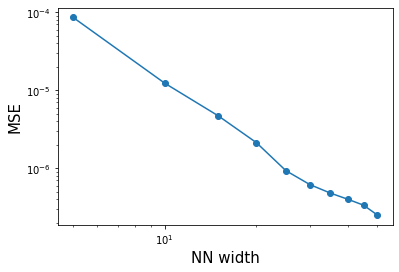

In [42]:
# Next try: relu2 (not just last layer)

plt.plot(ws, losses_w, marker="o")
#plt.plot(ws, losses_w_test, marker="o")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('NN width',fontsize=15)
plt.ylabel('MSE',fontsize=15)